In [24]:
from finn_examples.driver import FINNExampleOverlay
from qonnx.core.datatype import DataType
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [25]:
_cifar10_cnv_io_shape_dict = {
    "idt" : [DataType['UINT8']],
    "odt" : [DataType['UINT8']],
    "ishape_normal" : [(1, 32, 32, 3)],
    "oshape_normal" : [(1, 1)],
    "ishape_folded" : [(1, 32, 32, 3, 1)],
    "oshape_folded" : [(1, 1, 1)],
    "ishape_packed" : [(1, 32, 32, 3, 1)],
    "oshape_packed" : [(1, 1, 1)],
    "input_dma_name" : ['idma0'],
    "output_dma_name" : ['odma0'],
    "number_of_external_weights": 0,
    "num_inputs" : 1,
    "num_outputs" : 1,
}


In [26]:
!pwd

/home/root/jupyter_notebooks/case_2024/finn


In [27]:
# filename= "cnn_1w1a.bit"
filename="./models/cnv_1w1a_opt.bit"
driver_mode= "zynq-iodma"
accel= FINNExampleOverlay(filename, driver_mode, _cifar10_cnv_io_shape_dict, fclk_mhz= 200)

/usr/local/share/pynq-venv/lib/python3.8/site-packages/pynq/ps.py:434: UserWarning: Setting frequency to the closest possible value 214.28357MHz.
  warnings.warn(


In [28]:
from dataset_loading import cifar
trainx, trainy, testx, testy, valx, valy = cifar.load_cifar_data("/home/root/jupyter_notebooks/case_2024/dataset", download=True, one_hot=False)

Tar File found in dest_dir. Not Downloading again
Extracting Python CIFAR10 data.
Files extracted


In [29]:
test_single_x = testx[0]
test_single_y = testy[0]
cifar10_class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


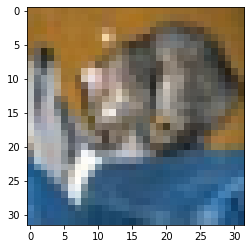

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.imshow(test_single_x)
plt.show()

In [31]:
test_single_x.shape

(32, 32, 3)

In [32]:
print("Expected class is %d (%s)" % (test_single_y, cifar10_class_names[test_single_y]))

Expected class is 3 (Cat)


In [33]:
accel_in = test_single_x.reshape(accel.ishape_normal())
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 32, 32, 3) and datatype is uint8


In [34]:
accel_out = accel.execute(accel_in)

In [35]:
accel_out

PynqBuffer([[3.]], dtype=float32)

In [36]:
print("Returned class is %d" % accel_out)

Returned class is 3


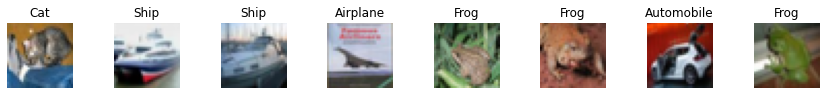

In [37]:
num_pics  = 8
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    
    accel_in = testx[i].reshape(accel.ishape_normal())
    accel_out = accel.execute(accel_in)
    prediction = accel_out

    ax[i].set_title(cifar10_class_names[int(prediction)])
    ax[i].axis('off')
    ax[i].imshow(testx[i])

In [38]:
accel.throughput_test()

{'runtime[ms]': 0.37670135498046875,
 'throughput[images/s]': 2654.6227848101266,
 'DRAM_in_bandwidth[MB/s]': 8.155001194936709,
 'DRAM_out_bandwidth[MB/s]': 0.0026546227848101263,
 'fclk[mhz]': 214.283571,
 'batch_size': 1,
 'fold_input[ms]': 0.03528594970703125,
 'pack_input[ms]': 0.03647804260253906,
 'copy_input_data_to_device[ms]': 0.24175643920898438,
 'copy_output_data_from_device[ms]': 0.09965896606445312,
 'unpack_output[ms]': 0.3654956817626953,
 'unfold_output[ms]': 0.05745887756347656}

In [39]:
from time import time

correct= 0
total= len(testx)
start = time()

for i in range(total):
    
    accel_in = testx[i].reshape(accel.ishape_normal())
    accel_out = accel.execute(accel_in)
    
    prediction = int(accel_out[0])
    if prediction==testy[i]:
        correct+=1

stop = time()
#correct = np.sum(clases_np[predictions]==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))    

Overall accuracy: 0.8262
  Execution time: 9.1954s
      Throughput: 1087.5006FPS


In [40]:
import numpy as np

batch_size = 1000
total = testx.shape[0]
accel.batch_size = batch_size
n_batches = int(total / batch_size)

batch_imgs = testx.reshape(n_batches, batch_size, -1)
batch_labels = testy.reshape(n_batches, batch_size)
obuf_normal = np.empty_like(accel.obuf_packed_device)
print("Ready to run validation, test images tensor has shape %s" % str(batch_imgs.shape))
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed()), str(accel.oshape_packed())))

Ready to run validation, test images tensor has shape (10, 1000, 3072)
Accelerator buffer shapes are (1000, 32, 32, 3, 1) for input, (1000, 1, 1) for output


In [41]:
ok = 0
nok = 0
for i in range(n_batches):
    ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal())
    exp = batch_labels[i]
    obuf_normal = accel.execute(ibuf_normal)
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    print("batch %d / %d : total OK %d NOK %d" % (i, n_batches, ok, nok))

batch 0 / 10 : total OK 839 NOK 161
batch 1 / 10 : total OK 1669 NOK 331
batch 2 / 10 : total OK 2483 NOK 517
batch 3 / 10 : total OK 3305 NOK 695
batch 4 / 10 : total OK 4127 NOK 873
batch 5 / 10 : total OK 4963 NOK 1037
batch 6 / 10 : total OK 5773 NOK 1227
batch 7 / 10 : total OK 6599 NOK 1401
batch 8 / 10 : total OK 7422 NOK 1578
batch 9 / 10 : total OK 8262 NOK 1738


In [42]:
acc = 100.0 * ok / (total)
print("Final accuracy: {}%".format(acc))

Final accuracy: 82.62%


In [43]:
def run_validation():
    for i in range(n_batches):
        ibuf_normal = batch_imgs[i].reshape(accel.ishape_normal())
        exp = batch_labels[i]
        accel.execute(ibuf_normal)

In [44]:
full_validation_time = %timeit -n 1 -o run_validation()

1.54 s ± 334 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
print("%f images per second including data movement" % (total / float(full_validation_time.best)))

6492.875243 images per second including data movement


In [46]:
run_validation()

In [47]:
del accel